# Introdução

Regression Discontinuity Design (RDD) é uma técnica de identificação causal que explora descontinuidades arbitrárias em regras de atribuição para estimar efeitos causais. A ideia central é que, próximo ao ponto de corte, a atribuição do tratamento é "quase aleatória".

## Como funciona
O RDD funciona quando existe uma regra clara que determina quem recebe um tratamento baseado em uma variável contínua (running variable) e um ponto de corte específico. Por exemplo:

 - Bolsas de estudo baseadas em notas acima de determinado valor
 - Programas sociais para pessoas com renda abaixo de certo limite
 - Medicamentos aprovados apenas para pacientes acima de determinada idade

A estratégia de identificação assume que indivíduos muito próximos ao ponto de corte são similares em características observáveis e não-observáveis, diferindo apenas no acesso ao tratamento.

## Tipos de RDD
- Sharp RDD: A probabilidade de tratamento muda de 0 para 1 (ou vice-versa) exatamente no ponto de corte.
- Fuzzy RDD: A probabilidade de tratamento muda, mas não necessariamente de forma completa no ponto de corte.

## Vantagens:

- Não requer randomização experimental
- Controla para características não-observáveis próximo ao cutoff
- Identificação causal mais forte que métodos observacionais tradicionais
- Transparente e fácil de visualizar

## Limitações:

- Validade local (apenas próximo ao cutoff)
- Requer amostra grande próximo ao ponto de corte
- Sensível à especificação do modelo e bandwidth
- Assume que não há manipulação da running variable

## Testes de robustez importantes:

- Teste de densidade: Verificar se há acúmulo suspeito de observações próximo ao cutoff
- Teste de balanceamento: Características pré-tratamento devem ser similares dos dois lados do cutoff
- Sensibilidade ao bandwidth: Resultados devem ser consistentes com diferentes larguras de banda
- Especificação funcional: Testar formas funcionais lineares vs. polinomiais


# Estudo de Caso 1

Este primeiro estudo de caso simula um programa de tutoria onde estudantes com nota abaixo de 60 recebem tutoria adicional. O código demonstra toda a pipeline: geração de dados, estimação, testes de robustez e visualizações. A técnica identifica o efeito causal comparando estudantes muito próximos ao ponto de corte, explorando a descontinuidade na regra de atribuição.

=== RDD COM BANDWIDTH ÓTIMO ===

Dados gerados: 800 observações
Efeito verdadeiro: +8 pontos

=== COMPARAÇÃO DE MÉTODOS DE BANDWIDTH ===

--- Imbens-Kalyanaraman ---
=== CÁLCULO DE BANDWIDTH ÓTIMO ===
Usando método Imbens-Kalyanaraman...
Detalhes do cálculo IK:
  - Variância esquerda: 36.917
  - Variância direita: 37.118
  - 2ª derivada esquerda: 0.0023
  - 2ª derivada direita: 0.0071
  - Curvatura total: 0.0094
  - Tamanho da amostra: 800
Bandwidth ótimo (IK): 5.00

Observações dentro do bandwidth: 141
Observações tratadas: 73
Observações controle: 68
Efeito estimado: 6.798
Erro padrão: 1.482
Erro de estimação: 1.202
Observações usadas: 141

--- Cross-Validation ---
=== CÁLCULO DE BANDWIDTH ÓTIMO ===
Usando método Cross-Validation...
Bandwidth ótimo (CV): 15.48

Observações dentro do bandwidth: 373
Observações tratadas: 194
Observações controle: 179
Efeito estimado: 8.214
Erro padrão: 0.826
Erro de estimação: 0.214
Observações usadas: 373

=== RESUMO COMPARATIVO ===
Método            

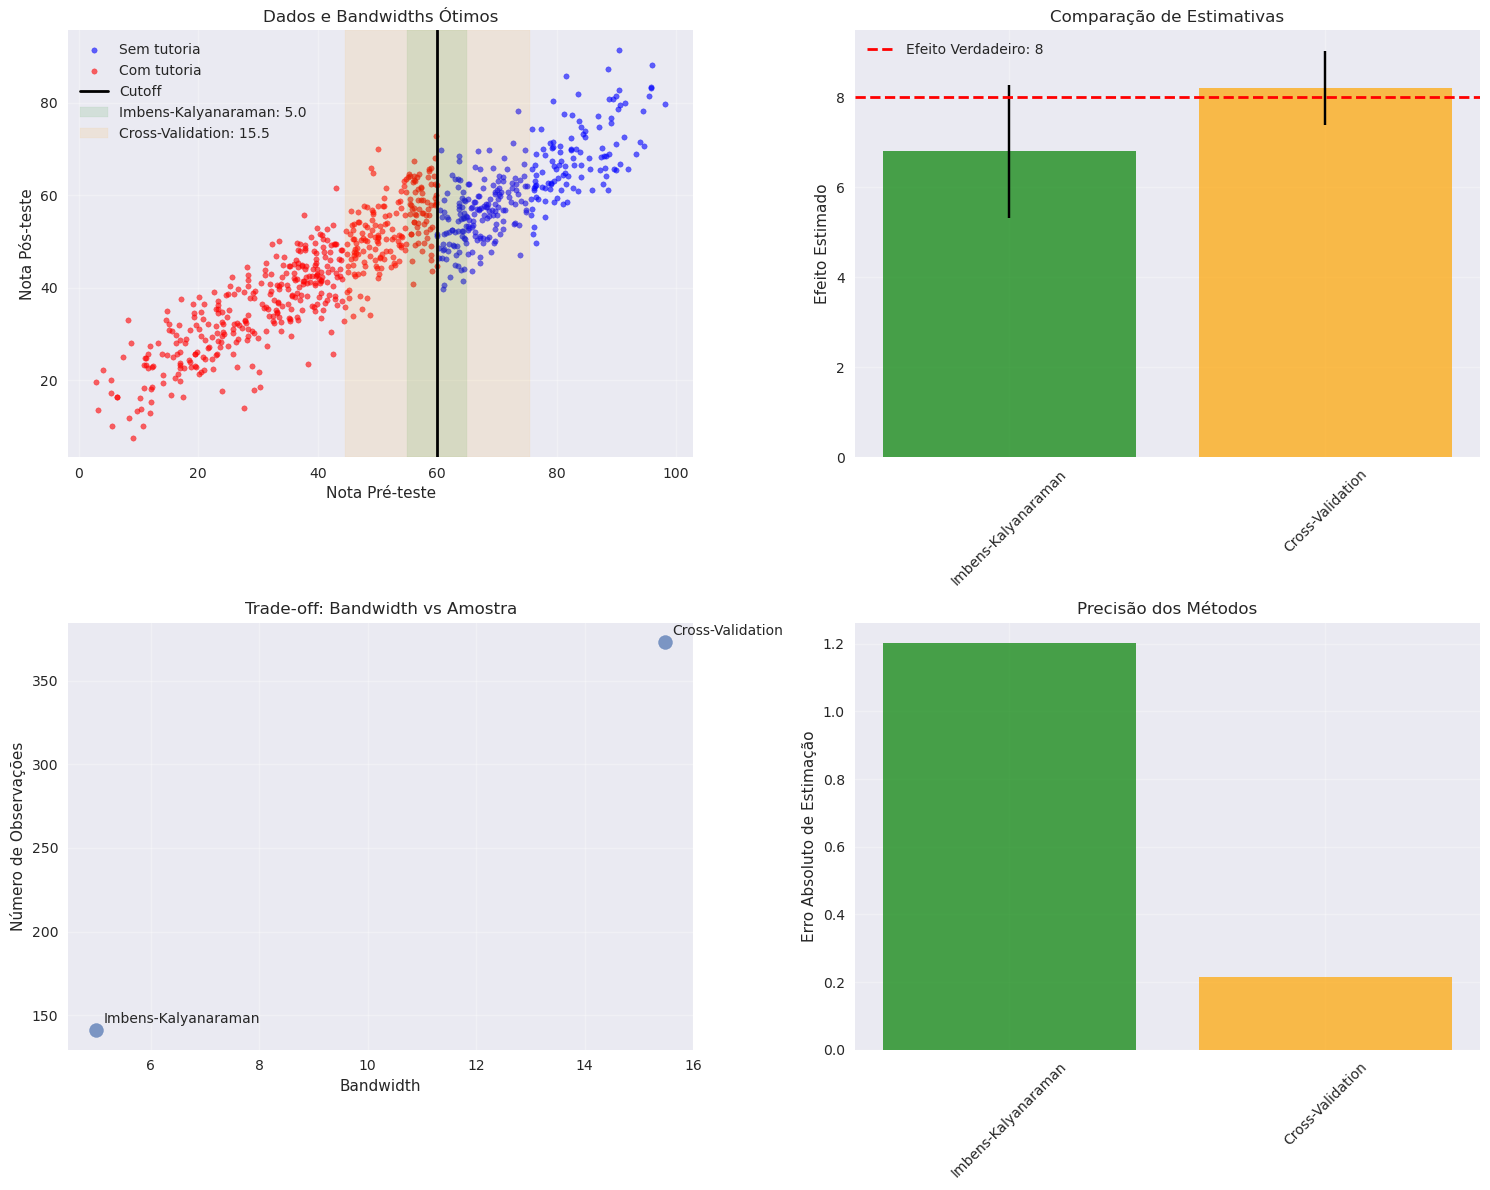


=== CONCLUSÕES ===
1. Imbens-Kalyanaraman: Método padrão acadêmico, base teórica sólida
2. Cross-Validation: Prático e intuitivo, funciona bem na prática


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

def gerar_dados_rdd(n=1000, cutoff=60, sharp=True):
    """Gera dados simulados para RDD"""
    
    # Running variable: notas do pré-teste
    running_var = np.random.beta(2, 2, n) * 100
    running_var = np.sort(running_var)
    
    # Variáveis de confusão
    habilidade_inicial = 0.3 * running_var + np.random.normal(0, 5, n)
    motivacao = np.random.normal(50, 10, n)
    
    # Regra de atribuição do tratamento
    if sharp:
        treatment = (running_var < cutoff).astype(int)
    else:
        prob_treatment = np.where(running_var < cutoff, 0.8, 0.2)
        treatment = np.random.binomial(1, prob_treatment, n)
    
    # Outcome com efeito verdadeiro de +8 pontos
    true_treatment_effect = 8
    
    outcome = (0.7 * running_var + 
               0.2 * habilidade_inicial + 
               0.1 * motivacao + 
               true_treatment_effect * treatment + 
               np.random.normal(0, 6, n))
    
    df = pd.DataFrame({
        'nota_pre': running_var,
        'tutoria': treatment,
        'nota_pos': outcome,
        'habilidade': habilidade_inicial,
        'motivacao': motivacao
    })
    
    return df, true_treatment_effect

def calcular_bandwidth_imbens_kalyanaraman(df, cutoff=60):
    """
    Implementa método Imbens-Kalyanaraman para bandwidth ótimo
    """
    
    # Centrar running variable
    df['x_centrado'] = df['nota_pre'] - cutoff
    
    # Separar dados por lado do cutoff
    left_side = df[df['x_centrado'] <= 0].copy()
    right_side = df[df['x_centrado'] > 0].copy()
    
    if len(left_side) < 20 or len(right_side) < 20:
        print("AVISO: Poucos dados próximos ao cutoff. Usando bandwidth padrão.")
        return 15.0
    
    # Função auxiliar para ajustar polinômio quadrático
    def fit_quadratic_side(data):
        if len(data) < 5:
            return np.array([0, 0, 0]), float('inf')
        
        X = np.column_stack([
            np.ones(len(data)), 
            data['x_centrado'], 
            data['x_centrado']**2
        ])
        
        try:
            coef = np.linalg.lstsq(X, data['nota_pos'], rcond=None)[0]
            # Calcular variância dos resíduos
            y_pred = X @ coef
            residual_var = np.var(data['nota_pos'] - y_pred)
            return coef, residual_var
        except:
            return np.array([0, 0, 0]), float('inf')
    
    # Ajustar regressões quadráticas em cada lado
    coef_left, var_left = fit_quadratic_side(left_side)
    coef_right, var_right = fit_quadratic_side(right_side)
    
    # Segunda derivada (2 * coeficiente de x²)
    second_deriv_left = 2 * coef_left[2] if len(coef_left) > 2 else 0
    second_deriv_right = 2 * coef_right[2] if len(coef_right) > 2 else 0
    
    # Parâmetros para fórmula IK
    n = len(df)
    sigma_sq = (var_left + var_right) / 2
    
    # Evitar valores extremos
    curvature = abs(second_deriv_left) + abs(second_deriv_right)
    if curvature < 1e-4:
        curvature = 1e-4
    
    # Constante de Imbens-Kalyanaraman
    C_IK = 3.4375
    
    # Fórmula do bandwidth ótimo
    h_opt = C_IK * (sigma_sq / curvature)**(1/5) * n**(-1/5)
    
    # Limitar a valores razoáveis
    h_opt = np.clip(h_opt, 5, 30)
    
    print(f"Detalhes do cálculo IK:")
    print(f"  - Variância esquerda: {var_left:.3f}")
    print(f"  - Variância direita: {var_right:.3f}")
    print(f"  - 2ª derivada esquerda: {second_deriv_left:.4f}")
    print(f"  - 2ª derivada direita: {second_deriv_right:.4f}")
    print(f"  - Curvatura total: {curvature:.4f}")
    print(f"  - Tamanho da amostra: {n}")
    
    return h_opt

def calcular_bandwidth_cross_validation(df, cutoff=60, bandwidth_range=(5, 25)):
    """
    Calcula bandwidth ótimo usando cross-validation
    """
    
    def mse_for_bandwidth(bw):
        # Filtrar dados dentro do bandwidth
        df_bw = df[np.abs(df['nota_pre'] - cutoff) <= bw].copy()
        
        if len(df_bw) < 15:
            return float('inf')
        
        # Preparar variáveis
        X = pd.DataFrame({
            'x_centrado': df_bw['nota_pre'] - cutoff,
            'tratamento': df_bw['tutoria']
        })
        X['x_tratamento'] = X['x_centrado'] * X['tratamento']
        
        y = df_bw['nota_pos']
        
        # Cross-validation
        try:
            modelo = LinearRegression()
            cv_scores = cross_val_score(modelo, X, y, cv=5, 
                                      scoring='neg_mean_squared_error')
            return -cv_scores.mean()
        except:
            return float('inf')
    
    # Otimização
    resultado = minimize_scalar(mse_for_bandwidth, 
                              bounds=bandwidth_range, 
                              method='bounded')
    
    return resultado.x

def analisar_rdd_com_bandwidth_otimo(df, cutoff=60, metodo='ik'):
    """
    Análise RDD com cálculo apropriado de bandwidth
    """
    
    print(f"=== CÁLCULO DE BANDWIDTH ÓTIMO ===")
    
    if metodo == 'ik':
        print("Usando método Imbens-Kalyanaraman...")
        bandwidth_otimo = calcular_bandwidth_imbens_kalyanaraman(df, cutoff)
        print(f"Bandwidth ótimo (IK): {bandwidth_otimo:.2f}\n")
        
    elif metodo == 'cv':
        print("Usando método Cross-Validation...")
        bandwidth_otimo = calcular_bandwidth_cross_validation(df, cutoff)
        print(f"Bandwidth ótimo (CV): {bandwidth_otimo:.2f}\n")
        
    else:
        # metodo inválido, retornar erro
        raise ValueError("Método inválido. Use 'ik' ou 'cv'.")

    
    # Aplicar bandwidth
    df['nota_pre_centrada'] = df['nota_pre'] - cutoff
    df['abaixo_cutoff'] = (df['nota_pre'] < cutoff).astype(int)
    
    df_rdd = df[np.abs(df['nota_pre_centrada']) <= bandwidth_otimo].copy()
    
    print(f"Observações dentro do bandwidth: {len(df_rdd)}")
    print(f"Observações tratadas: {df_rdd['tutoria'].sum()}")
    print(f"Observações controle: {len(df_rdd) - df_rdd['tutoria'].sum()}")
    
    return df_rdd, bandwidth_otimo

def estimar_efeito_rdd(df_rdd):
    """
    Estima efeito do tratamento
    """
    
    X = df_rdd[['nota_pre_centrada', 'abaixo_cutoff']].copy()
    X['nota_pre_x_tratamento'] = X['nota_pre_centrada'] * X['abaixo_cutoff']
    y = df_rdd['nota_pos']
    
    modelo = LinearRegression()
    modelo.fit(X, y)
    
    efeito_tratamento = modelo.coef_[1]
    
    # Erro padrão
    y_pred = modelo.predict(X)
    residuos = y - y_pred
    mse = np.mean(residuos**2)
    
    X_matrix = X.values
    try:
        cov_matrix = mse * np.linalg.inv(X_matrix.T @ X_matrix)
        erro_padrao = np.sqrt(cov_matrix[1, 1])
    except:
        erro_padrao = np.nan
    
    return {
        'efeito_tratamento': efeito_tratamento,
        'erro_padrao': erro_padrao,
        'modelo': modelo
    }

def comparar_metodos_bandwidth(df, cutoff=60, efeito_verdadeiro=8):
    """
    Compara diferentes métodos de bandwidth
    """
    
    print("=== COMPARAÇÃO DE MÉTODOS DE BANDWIDTH ===\n")
    
    metodos = {
        'Imbens-Kalyanaraman': 'ik',
        'Cross-Validation': 'cv'
    }
    
    resultados = {}
    
    for nome_metodo, codigo_metodo in metodos.items():
        print(f"--- {nome_metodo} ---")
        
        df_rdd, bandwidth = analisar_rdd_com_bandwidth_otimo(df, cutoff, codigo_metodo)
        resultado = estimar_efeito_rdd(df_rdd)
        
        resultados[nome_metodo] = {
            'bandwidth': bandwidth,
            'efeito': resultado['efeito_tratamento'],
            'erro_padrao': resultado['erro_padrao'],
            'n_obs': len(df_rdd)
        }
        
        erro_estimacao = abs(resultado['efeito_tratamento'] - efeito_verdadeiro)
        
        print(f"Efeito estimado: {resultado['efeito_tratamento']:.3f}")
        print(f"Erro padrão: {resultado['erro_padrao']:.3f}")
        print(f"Erro de estimação: {erro_estimacao:.3f}")
        print(f"Observações usadas: {len(df_rdd)}\n")
    
    # Resumo comparativo
    print("=== RESUMO COMPARATIVO ===")
    print(f"{'Método':<30} | {'Bandwidth':<10} | {'Efeito':<8} | {'Erro Est.':<8} | {'N obs':<6}")
    print("-" * 70)
    
    for nome, res in resultados.items():
        erro_est = abs(res['efeito'] - efeito_verdadeiro)
        print(f"{nome:<30} | {res['bandwidth']:<10.2f} | {res['efeito']:<8.3f} | "
              f"{erro_est:<8.3f} | {res['n_obs']:<6}")
    
    print(f"\nEfeito verdadeiro: {efeito_verdadeiro}")
    
    return resultados

def plotar_comparacao_bandwidth(df, resultados, cutoff=60):
    """
    Visualiza comparação entre métodos
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Dados e bandwidths
    ax1 = axes[0, 0]
    
    tratados = df[df['tutoria'] == 1]
    controle = df[df['tutoria'] == 0]
    
    ax1.scatter(controle['nota_pre'], controle['nota_pos'], 
               alpha=0.6, color='blue', label='Sem tutoria', s=15)
    ax1.scatter(tratados['nota_pre'], tratados['nota_pos'], 
               alpha=0.6, color='red', label='Com tutoria', s=15)
    
    ax1.axvline(x=cutoff, color='black', linestyle='-', linewidth=2, label='Cutoff')
    
    # Mostrar diferentes bandwidths
    cores = ['green', 'orange']
    i = 0
    for nome, res in resultados.items():
        bw = res['bandwidth']
        ax1.axvspan(cutoff - bw, cutoff + bw, alpha=0.1, color=cores[i], 
                    label=f'{nome.split()[0]}: {bw:.1f}')
        i += 1
    
    ax1.set_xlabel('Nota Pré-teste')
    ax1.set_ylabel('Nota Pós-teste')
    ax1.set_title('Dados e Bandwidths Ótimos')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Comparação de efeitos
    ax2 = axes[0, 1]
    
    metodos = []
    efeitos = []
    erros = []
    
    for nome, res in resultados.items():
        metodos.append(nome.split()[0])  # Pegar primeira palavra
        efeitos.append(res['efeito'])
        erros.append(res['erro_padrao'])
    
    x_pos = range(len(metodos))
    bars = ax2.bar(x_pos, efeitos, yerr=erros, capsize=5, alpha=0.7,
                   color=['green', 'orange', 'gray'])
    
    ax2.axhline(y=8, color='red', linestyle='--', linewidth=2, label='Efeito Verdadeiro: 8')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(metodos, rotation=45)
    ax2.set_ylabel('Efeito Estimado')
    ax2.set_title('Comparação de Estimativas')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Bandwidth vs Número de observações
    ax3 = axes[1, 0]
    
    bandwidths = [res['bandwidth'] for res in resultados.values()]
    n_obs = [res['n_obs'] for res in resultados.values()]
    
    ax3.scatter(bandwidths, n_obs, s=100, alpha=0.7)
    
    for i, (nome, res) in enumerate(resultados.items()):
        ax3.annotate(nome.split()[0], 
                    (res['bandwidth'], res['n_obs']),
                    xytext=(5, 5), textcoords='offset points')
    
    ax3.set_xlabel('Bandwidth')
    ax3.set_ylabel('Número de Observações')
    ax3.set_title('Trade-off: Bandwidth vs Amostra')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Precisão das estimativas
    ax4 = axes[1, 1]
    
    erros_estimacao = [abs(res['efeito'] - 8) for res in resultados.values()]
    
    ax4.bar(range(len(metodos)), erros_estimacao, alpha=0.7,
           color=['green', 'orange', 'gray'])
    ax4.set_xticks(range(len(metodos)))
    ax4.set_xticklabels(metodos, rotation=45)
    ax4.set_ylabel('Erro Absoluto de Estimação')
    ax4.set_title('Precisão dos Métodos')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def main():
    print("=== RDD COM BANDWIDTH ÓTIMO ===\n")
    
    # Gerar dados
    df, efeito_verdadeiro = gerar_dados_rdd(n=800, cutoff=60, sharp=True)
    print(f"Dados gerados: {len(df)} observações")
    print(f"Efeito verdadeiro: +{efeito_verdadeiro} pontos\n")
    
    # Comparar métodos
    resultados = comparar_metodos_bandwidth(df, cutoff=60, 
                                          efeito_verdadeiro=efeito_verdadeiro)
    
    # Visualizações
    plotar_comparacao_bandwidth(df, resultados, cutoff=60)
    
    print("\n=== CONCLUSÕES ===")
    print("1. Imbens-Kalyanaraman: Método padrão acadêmico, base teórica sólida")
    print("2. Cross-Validation: Prático e intuitivo, funciona bem na prática")
    
    return df, resultados

if __name__ == "__main__":
    df, resultados = main()

# Estudo de Caso 2

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Criando um DataFrame com os dados
data_rd = {'nota_exame': [80, 70, 85, 60, 78, 73],
           'bolsa': ['Sim', 'Não', 'Sim', 'Não', 'Sim', 'Não']}

df_rd = pd.DataFrame(data_rd)

# Criando a variável indicadora para o tratamento (1 para Bolsa, 0 para Não Bolsa)
df_rd['tratamento'] = df_rd['bolsa'].apply(lambda x: 1 if x == 'Sim' else 0)

# Especificando a variável de corte
threshold = 75

# Criando uma variável indicadora para estar acima ou abaixo do threshold
df_rd['acima_threshold'] = (df_rd['nota_exame'] > threshold).astype(int)

# Ajustando o modelo de regressão descontínua
model_rd = sm.OLS(df_rd['tratamento'], sm.add_constant(df_rd['acima_threshold']))
result_rd = model_rd.fit()

# Imprimindo os resultados
print(result_rd.summary())

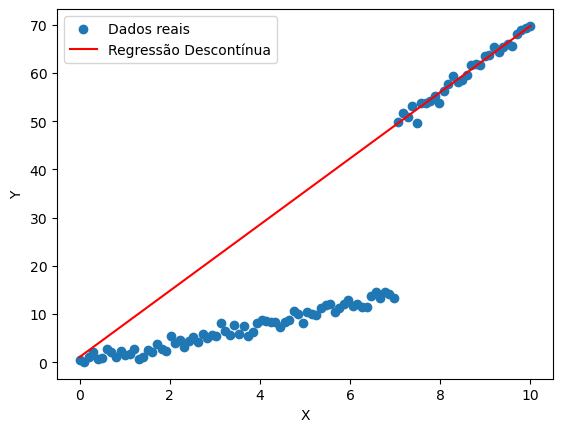

In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Gerar dados com mudança na relação
np.random.seed(42)
X = np.linspace(0, 10, 100)
Y = 2*X + np.random.normal(0, 1, 100)

# Introduzir uma mudança na relação
Y[70:] = Y[70:] + 5*X[70:]

# Adicionar variável indicadora para a mudança
indicadora = (X >= 7).astype(int)

# Adicionar coluna de uns para termo constante
X = sm.add_constant(X)

# Criar modelo de regressão descontínua
modelo = sm.OLS(Y, X).fit()

# Adicionar variável indicadora ao modelo
modelo = sm.OLS(Y, X * indicadora.reshape(-1, 1)).fit()

# Fazer previsões usando o modelo
previsoes = modelo.predict(X)

# Plotar os resultados
plt.scatter(X[:, 1], Y, label='Dados reais')
plt.plot(X[:, 1], previsoes, color='red', label='Regressão Descontínua')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


In [4]:
# %load ../src/rdd/dataset.py
import numpy as np 
import pandas as pd

def generate_data(seed, obs, std_dev, eligibility_threshold, treatment_effect, 
                positive_slope = True, after_cutoff = True):

    """
    This function generates spoofed data for our example. Although the running variable and target
    variables we test can be modified for specific purposes,they must be continuous.

    We generate our running variables values utilizing a uniform random variable. We then
    choose to treat if the running variable's valuesfall below the cutoff point We can change
    the sign based on the application. After this point, we choose to generate the data.

    INPUTS
    ------
    - seed: random state value included for reproducability
    - obs: integer representing number of observations
    - std_dev: constant that represents change between pre/post test values
    - treatment_effect: constant representing the base level of change

    OUTPUT
    ------
    spoofed_data: pandas dataframe containing the independent and target variables,
    as well as a binary indicator for treatment status
    """


    # initialize random state, generate data
    random_state = np.random.default_rng(seed) 
    running_variable = random_state.normal(loc = eligibility_threshold, size=obs) 

    #There are four cases:

    #Case 1: Positive Slope, Treatment Above the Cutoff 

    if (positive_slope == True) & (after_cutoff == True):
        # Apply Treatment above Cutoff
        treat = np.where(running_variable > eligibility_threshold, True, False)
        
        # Treatment Effect Discontinuity
        value_error = random_state.normal(0, std_dev, obs) + (treatment_effect * treat)
        y = running_variable + value_error

        # RETURN Pandas DF
        spoofed_data = pd.DataFrame(
            {
                "X": running_variable,
                "treatment": treat,
                "Y":y,
            }
        )
        return spoofed_data
    
    # Case 2: Positive Slope, Treatment Below Cutoff 

    elif (positive_slope == True) & (after_cutoff == False):
        # Apply Treatment above Cutoff
        treat = np.where(running_variable < eligibility_threshold, True, False)
        
        # Treatment Effect Discontinuity
        value_error = random_state.normal(0, std_dev, obs) + (treatment_effect * treat)
        y = running_variable + value_error

        # RETURN Pandas DF
        spoofed_data = pd.DataFrame(
            {
                "X": running_variable,
                "treatment": treat,
                "Y":y,
            }
        )
        return spoofed_data

    # Case 3: Negatove Slope, Treatment Above Cutoff    

    elif (positive_slope == False) & (after_cutoff == True):
        # Apply Treatment above Cutoff
        treat = np.where(running_variable > eligibility_threshold, True, False)
        
        # Treatment Effect Discontinuity
        value_error = random_state.normal(0, std_dev, obs) + (treatment_effect * treat)
        y = - running_variable + value_error

        # RETURN Pandas DF
        spoofed_data = pd.DataFrame(
            {
                "X": running_variable,
                "treatment": treat,
                "Y":y,
            }
        )
        return spoofed_data

    elif (positive_slope == False) & (after_cutoff == False):
        # Apply Treatment above Cutoff
        treat = np.where(running_variable < eligibility_threshold, True, False)
        
        # Treatment Effect Discontinuity
        value_error = random_state.normal(0, std_dev, obs) + (treatment_effect * treat)
        y = - running_variable + value_error

        # RETURN Pandas DF
        spoofed_data = pd.DataFrame(
            {
                "X": running_variable,
                "treatment": treat,
                "Y":y,
            }
        )
        return spoofed_data

In [5]:
# Load packages and scripts 
import numpy as np 

# Initialize random state value for reproducability
SEED = 16121515132518 #Ploomber
random_state = np.random.default_rng(SEED)

# Declare data generation parameters 
N = 10**4 # number of observations
TE = 2 # treatment effect we evaluate post-policy
STD = 0.3 # noise between pre-post changes in Y values, no measurement error
ELIGIBILITY_THRESHOLD = 5 #cutoff point

# Generate data into pandas dataFrame 
df = generate_data(SEED, N, STD, ELIGIBILITY_THRESHOLD, TE, positive_slope= True, after_cutoff= True)

df.head(15)

,X,treatment,Y
0,4.870078,False,4.581683
1,5.215001,True,7.389128
2,4.411041,False,4.524965
3,5.515494,True,7.275432
4,6.823859,True,9.273906
5,5.729496,True,7.243352
6,5.019296,True,7.632244
7,5.767535,True,7.730414
8,4.307496,False,3.652588
9,4.681779,False,5.251716


In [6]:
df.shape

(10000, 3)

In [14]:
#!conda install arviz

In [ ]:
#!conda install seaborn

In [12]:
# %load ../src/rdd/visuals.py
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


def data_scatterplot(data, eligibility_threshold):

    """
    Take spoofed scatterplot data (features: X, treatment indicator, Y) and then plot
    utilizing matplotlib.

    INPUTS
    ------
    - df: pandas dataframe

    OUTPUTS
    -------
    - Scatterplot demarcating treatment and control groups, in addition to eligibility threshold
    """

    # set dimensions of graph, theme for contrast
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize=(16, 9))

    # plot treated values as scatter
    ax.scatter(
        data.X[data.treatment],
        data.Y[data.treatment],
        alpha=0.4,
        s=5,
        label="Treated Group",
    )

    # plot untreated values as scatter
    ax.scatter(
        data.X[~data.treatment],
        data.Y[~data.treatment],
        alpha=0.4,
        s=5,
        label="Untreated Group",
    )

    # plot vertical line denoting cutoff
    plt.axvline(
        x=eligibility_threshold, ls="-", color="black", label="Eligibility Threshold"
    )

    # labels and legends
    ax.set_xlabel("X Values - Pre/Post Program")
    ax.set_ylabel("Y Values - Post Program")
    ax.set_title("General Sharp RDD Setup")
    ax.legend()

    return ax


def diagnostic_plots(inf_data, treatment_effect, std):

    """
    Check the validity of our priors based on returned inference data

    INPUTS
    ------
    - inf_data: inference data object returned from train_model function
    - treatment_effect: specified treatment effect that we defined in our data
    - std: variation in points around our linear regressions defined in our data

    OUTPUTS:
    --------
    A set of plots mapping the validity of our delta and sigma priors.
    Plots should converge without difficults, and means should be within a 95% confidence interval
    """

    # MCMC Trace
    az.plot_trace(inf_data, var_names=["effect", "sigma"])

    # Posterior Histogram
    az.plot_posterior(
        inf_data,
        var_names=["effect", "sigma"],
        ref_val=[treatment_effect, std],
        hdi_prob=0.95,
    )


def regression_discontinuity_plot(
    data, eligibility_threshold, trained_mod, inf_data
):

    """
    Plots linear regression lines on top of data_scatterplot function to illustrate
    regression discontinuity effects. Samples posterior data from by train_model function
    in model.py to construct high density interval from our regression lines.

    INPUTS
    ------
    - df: data generated from dataset.py
    - trained_mod: our model trained in model.py
    - inf_data: our inference data generated in model.py

    OUTPUT
    ------
    Plot illustrating treatment group regression, control group regression, and
    scatterplot data from data_scatterplot.
    """

    sns.set_style("darkgrid")

    # instantiate data for future sampling
    mu_x = np.linspace(np.min(data.X), np.max(data.X), 500)
    lab_treated = np.zeros(mu_x.shape)

    # use aliases found in model.py file for lines
    with trained_mod:
        pm.set_data({"x_vals": mu_x, "treated_obs": lab_treated})
        ppc = pm.sample_posterior_predictive(inf_data, var_names=["mu", "y"])

    # scatterplot for treatment,control,eligibility threshold
    ax = data_scatterplot(data, eligibility_threshold)

    # plot control group's regression line, labels for mu
    az.plot_hdi(
        mu_x,
        ppc.posterior_predictive["mu"],
        color="C1",
        hdi_prob=0.95,
        ax=ax,
        fill_kwargs={"label": r"$\mu$ untreated (Counterfactual)"},
    )

    # instantiate data for future sampling
    mu_x = np.linspace(np.min(data.X), np.max(data.X), 500)
    lab_treated = np.ones(mu_x.shape)

    # use aliases found in model.py file
    with trained_mod:
        pm.set_data({"x_vals": mu_x, "treated_obs": lab_treated})
        ppc = pm.sample_posterior_predictive(inf_data, var_names=["mu", "y"])

    # plot treatment's regression line, labels for mu
    az.plot_hdi(
        mu_x,
        ppc.posterior_predictive["mu"],
        color="C0",
        hdi_prob=0.95,
        ax=ax,
        fill_kwargs={"label": r"$\mu$ treated (Actual Trend)"},
    )

    plt.legend()
    plt.show()


<Axes: title={'center': 'General Sharp RDD Setup'}, xlabel='X Values - Pre/Post Program', ylabel='Y Values - Post Program'>

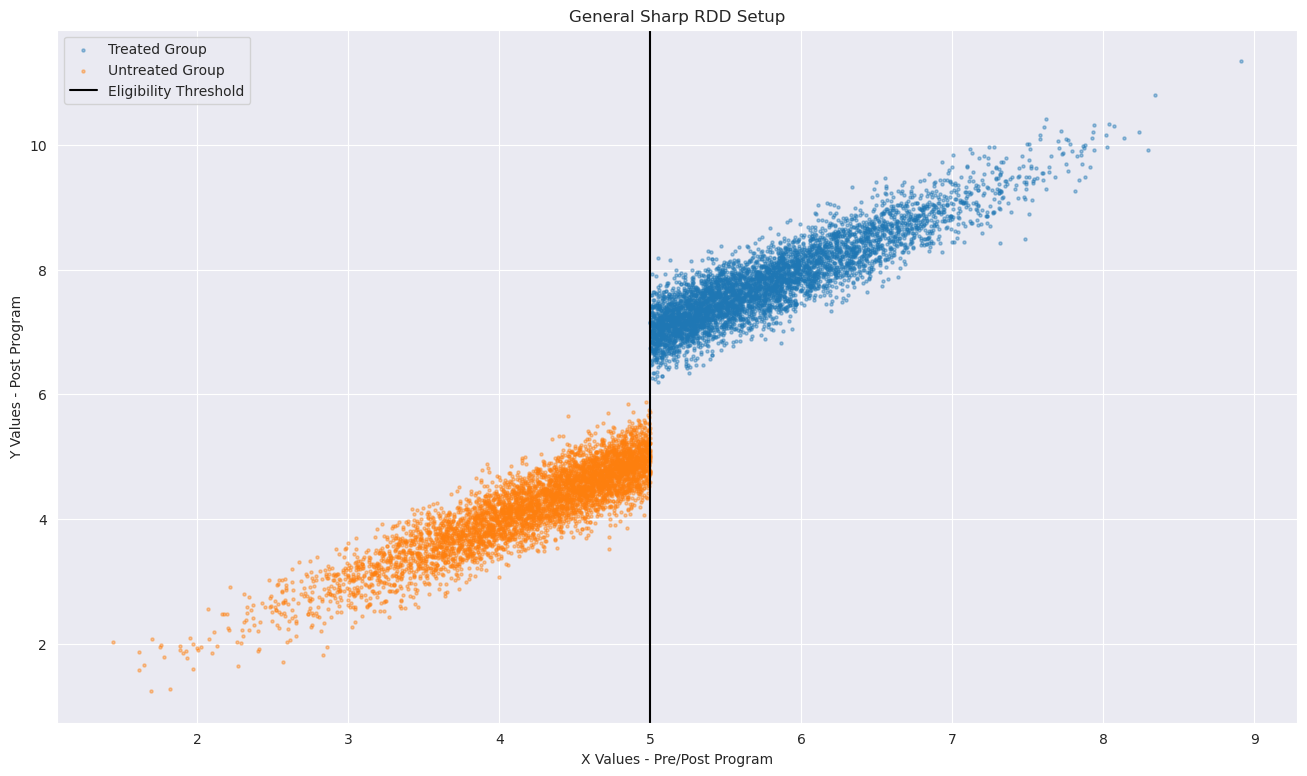

In [13]:
#visualizations adjust for the eligbility threshold specified
data_scatterplot(df, ELIGIBILITY_THRESHOLD)

                            OLS Regression Results                            
Dep. Variable:                MedCost   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     253.6
Date:                Wed, 15 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:00:11   Log-Likelihood:                -22843.
No. Observations:                3000   AIC:                         4.570e+04
Df Residuals:                    2991   BIC:                         4.576e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

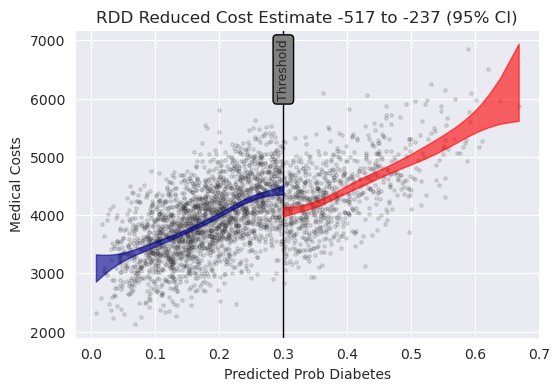

In [15]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

########################################
# Simulating data
np.random.seed(10)
n_cases = 3000 # total number of cases
# pretend this is predicted prob
prob = np.random.beta(3,10,size=n_cases)
# pretend this is med costs over a year
med_cost = 3000 + 5000*prob + -500*(prob > 0.3) + np.random.normal(0,500,n_cases)
df = pd.DataFrame(zip(prob,med_cost), columns=['Prob','MedCost'])
# could do something fancier with non-linear effects for prob
########################################

########################################
# Fitting regression model

# Knots are small distance from threshold
# (Could also do a knot right on threshold)
mod = smf.ols(formula='MedCost ~ bs(Prob,knots=[0.2,0.25,0.35,0.4]) + I(Prob > 0.3)', data=df)
res = mod.fit()
print(res.summary())
########################################

########################################
# Plotting fit

# Getting standard errors
prob_se = res.get_prediction().summary_frame()
prob_se['Prob'] = prob
prob_se.sort_values(by='Prob',inplace=True,ignore_index=True)
low = prob_se[prob_se['Prob'] <= 0.3].copy()
high = prob_se[prob_se['Prob'] > 0.3].copy()

# Getting effect for threshold bump
coef = res.summary2().tables[1]
ci = coef.iloc[1,4:6].astype(int).to_list()

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(df['Prob'], df['MedCost'], c='grey',
           edgecolor='k', alpha=0.15, s=5, zorder=1)
ax.axvline(0.3, linestyle='solid', alpha=1.0, 
           color='k',linewidth=1, zorder=2)
ax.fill_between(low['Prob'],low['mean_ci_lower'],
                low['mean_ci_upper'],alpha=0.6,
                zorder=3, color='darkblue')
ax.fill_between(high['Prob'],high['mean_ci_lower'],
                high['mean_ci_upper'],alpha=0.6,
                zorder=3, color='red')
ax.set_xlabel('Predicted Prob Diabetes')
ax.set_ylabel('Medical Costs')
ax.set_title(f'RDD Reduced Cost Estimate {ci[0]} to {ci[1]} (95% CI)')
ax.text(0.3,6500,'Threshold',rotation=90, size=9,
         ha="center", va="center",
         bbox=dict(boxstyle="round", ec='k',fc='grey'))
plt.savefig('RDD.png', dpi=500, bbox_inches='tight')
########################################